# Expression Machine Learning 

## Loading packages 

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import statistics
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import mannwhitneyu
from scipy.stats import fisher_exact
from scipy.stats import chi2_contingency
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from statsmodels.stats.multitest import fdrcorrection


## Load Data

In [26]:
features = pd.read_csv("features_human_proteome_no_filtering.csv")
features.rename(columns = {'id':'UniprotID'}, inplace = True)
pd.set_option('display.max_rows', 500)
LP_pred = pd.read_csv("LHP_PREDICTIONS.tsv", sep='\t')
LP_pred.rename(columns = {'id':'UniprotID', 'prediction':'LHPpred'}, inplace = True)
df = LP_pred.merge(features, on='UniprotID', how='left')
Expression = pd.read_csv('ExpressionGenesAndUniprot.csv', index_col=0)

max_exp = Expression.groupby(['Gene','Gene_name', 'Uniprot_ID']).agg({'Tissue': lambda x: ",".join(x), 'NX':'max'}).rename({'NX' : 'max_NX'},axis=1).reset_index()
max_exp.rename(columns = {'Uniprot_ID':'UniprotID'}, inplace = True)
max_exp = max_exp.drop(["Tissue","Gene_name", "Gene"],axis=1 )
df = df.merge(max_exp, on='UniprotID', how='left')
test = df.copy()
df = df.select_dtypes(['number'])
original = df
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
original.dropna(axis=0, how='any', thresh=None, subset=None, inplace=True)
len(original)

18834

/Users/priya/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


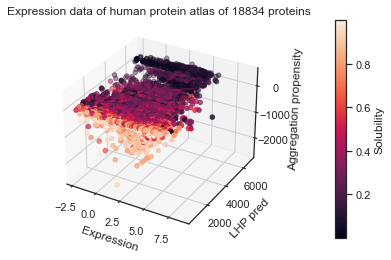

In [27]:
figsize=(8,4)
sns.set(style=("ticks"))
sns.set_palette("rocket")
fig = plt.figure()
ax = plt.axes(projection='3d')
color_map = plt.get_cmap('rocket')
p = ax.scatter3D(np.log(df['max_NX']) , df['LHPpred'], df['Aggregation_propensity'], c= df['Prob. of Solubility'],cmap =color_map )
ax.set_xlabel("Expression")
ax.set_ylabel("LHP pred")
ax.set_zlabel("Aggregation propensity")
fig.colorbar(p,pad=0.2,label="Solubility" )
ax.set_title("Expression data of human protein atlas of 18834 proteins")
plt.savefig('Figures/3Dplot.png',dpi=300, bbox_inches='tight')
plt.show()



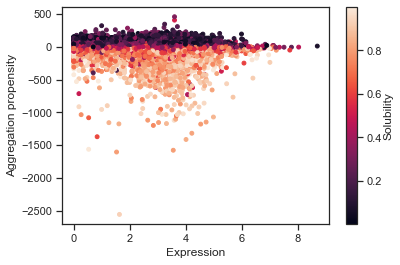

In [28]:
sns.set_palette("rocket")
sns.set(style=("ticks"))
marker_size=15
plt.scatter(np.log(df['max_NX']+1),df['Aggregation_propensity'] , marker_size, c=df['Prob. of Solubility'])
plt.xlabel("Expression")
plt.ylabel("Aggregation propensity")
cbar= plt.colorbar()
cbar.set_label("Solubility", labelpad=+1)
plt.savefig('Figures/2Dplot.png',dpi=300, bbox_inches='tight')
plt.show()

In [29]:
# test.loc[test["max_NX"].idxmax()]
# Expression.loc[Expression["Uniprot_ID"]=="P02808"]

# test.loc[test["Aggregation_propensity"].idxmax()]
# Expression.loc[Expression["Uniprot_ID"]=="Q86UQ4"]


test.loc[test["Aggregation_propensity"].idxmin()]
Expression.loc[Expression["Uniprot_ID"]=="P20930"]


Gene Gene_name                 Tissue   NX Uniprot_ID
126579  ENSG00000143631       FLG               appendix  0.0     P20930
126580  ENSG00000143631       FLG                 breast  4.1     P20930
126581  ENSG00000143631       FLG                  colon  0.0     P20930
126582  ENSG00000143631       FLG               duodenum  0.0     P20930
126583  ENSG00000143631       FLG         fallopian tube  0.0     P20930
126584  ENSG00000143631       FLG  hippocampal formation  0.0     P20930
126585  ENSG00000143631       FLG                   lung  0.0     P20930
126586  ENSG00000143631       FLG               NK-cells  0.0     P20930
126587  ENSG00000143631       FLG      parathyroid gland  0.0     P20930
126588  ENSG00000143631       FLG               prostate  0.0     P20930
126589  ENSG00000143631       FLG        seminal vesicle  0.0     P20930
126590  ENSG00000143631       FLG          smooth muscle  0.0     P20930
126591  ENSG00000143631       FLG                T-cells  0.0     P20930
126592  ENSG00000143631       FLG          thyroid gland  0.0     P20930
126593  ENSG00000143631       FLG        urinary bladder  0.0     P20930

https://www.uniprot.org/uniprotkb/P02808/entry
https://www.uniprot.org/uniprotkb/Q86UQ4/entry
P20930

/var/folders/3j/bhbg34qd24553j30j22dbny40000gn/T/ipykernel_24108/172065606.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)


Text(0.5, 1.0, 'Expression data from Human Proteome Atlas')

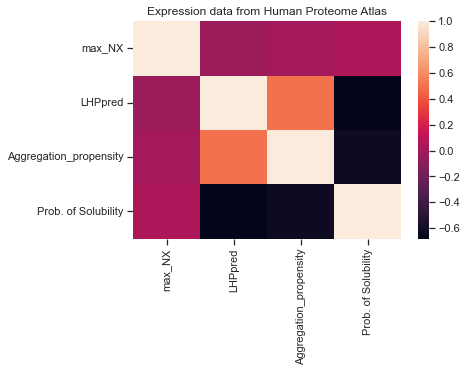

In [30]:
df_corr = df.filter(['max_NX' , 'LHPpred', 'Aggregation_propensity','Prob. of Solubility' ],axis=1)
corr = df_corr.corr()
ax = plt.axes()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool),square=False, ax=ax)
ax.set_title('Expression data from Human Proteome Atlas')

In [31]:
percentile = np.percentile(df['max_NX'], np.arange(0, 100, 10))
max_percent = max(percentile)
percentile

# sns.violinplot(x=percentile, y=df['max_NX'])
df["first_quantile"]  = pd.Series(np.where(df['max_NX']<percentile[1], 1, 0),df.index)
df["last_quantile"]  = pd.Series(np.where(df['max_NX']>percentile[-1], 1, 0),df.index)


### If high expression, binary_exp =1 and if low expression binary_exp =0

In [32]:
new_df = df.loc[(df['first_quantile'] == 1) | (df['last_quantile'] ==1)].reset_index(drop=True)
new_df.rename(columns = {'last_quantile':'Binary_exp'}, inplace = True)
new_df =new_df.drop(["first_quantile"], axis = 1)
new_df.columns.values

array(['LHPpred', 'length', 'hydr_count', 'polar_count',
       'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E',
       'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T',
       'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2',
       'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed',
       'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed', 'H_exposed',
       'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed',
       'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed',
       'V_exposed', 'W_exposed', 'Y_exposed', 'Prob. of Solubility',
       'Aggregation_propensity', 'Aromaticity', 'Instability_index',
       'Gravy', 'isoelectric_point', 'charge_at_7', 'charge_at_5', 'HSP',
       'PTM_UP', 'Citrullination_UP', 'GPI-anchor_UP', 'Lipoprotein_UP',
       'Nitration_UP', 'Prenylation_UP', 'ISGylation_UP',
       'NEDDylation_UP', 'Acetylation_all', 'Glycosylation_all',
       'Methylation_all', 'Myristoylation_all', 'Nitr

In [33]:
seq_features = ['Binary_exp','length', 'hydr_count', 'polar_count', 'molecular_weight', 'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 
                'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2', 'tasa_netsurfp2', 
                'rhsa_netsurfp2', 'disorder', 'A_exposed', 'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed',
                'G_exposed', 'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed', 'N_exposed', 'P_exposed', 
                'Q_exposed', 'R_exposed', 'S_exposed', 'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed', 
                'Prob. of Solubility','Aggregation_propensity', 'Aromaticity', 'Instability_index', 'Gravy', 
                'isoelectric_point', 'charge_at_7', 'charge_at_5', 'PTM_MSD', 'Phosphorylation_MSD',
                'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD', 'Acetylation_MSD', 'Palmitoylation_MSD', 
                'Methylation_MSD', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred']
len(seq_features)

71

In [34]:
def get_normalised_df(df):
    df_min_max_scaled = df.copy()
    # apply normalization to all columns
    for column in df_min_max_scaled:
        if column != 'Binary_exp':
            df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())    
    return df_min_max_scaled

In [35]:
new_df = new_df[seq_features]
Final_DNASU_ML = get_normalised_df(new_df)#TRAINING DATASET
# Final_DNASU_ML.isnull().sum()
# Final_DNASU_ML = df
Final_DNASU_ML


Binary_exp    length  hydr_count  polar_count  molecular_weight  \
0              0  0.554402    0.367145     0.592698          0.559611   
1              0  0.442007    0.720201     0.368240          0.449309   
2              1  0.430051    0.585633     0.458318          0.434896   
3              1  0.224390    0.583529     0.467462          0.228173   
4              1  0.260157    0.595269     0.445957          0.267650   
...          ...       ...         ...          ...               ...   
3744           1  0.365284    0.596333     0.455908          0.364361   
3745           0  0.554215    0.578742     0.453950          0.559569   
3746           1  0.395932    0.557094     0.569105          0.403998   
3747           0  0.260157    0.431286     0.488131          0.266491   
3748           0  0.460781    0.735645     0.396753          0.471799   

         helix      turn     sheet         A         C  ...  \
0     0.185629  0.774334  0.061044  0.233553  0.052290  ...   
1     0.498420  0.371990  0.197581  0.261671  0.095472  ...   
2     0.451989  0.338158  0.319955  0.341346  0.045093  ...   
3     0.632673  0.367327  0.000000  0.307550  0.000000  ...   
4     0.567042  0.432958  0.000000  0.209646  0.114736  ...   
...        ...       ...       ...       ...       ...  ...   
3744  0.468445  0.372691  0.242215  0.498996  0.048766  ...   
3745  0.411788  0.526262  0.094454  0.308234  0.069803  ...   
3746  0.318010  0.558133  0.188840  0.263614  0.120226  ...   
3747  0.175703  0.768391  0.085237  0.209646  0.038245  ...   
3748  0.711547  0.288453  0.000000  0.203023  0.052910  ...   

      Phosphorylation_MSD  Glycosylation_MSD  Ubiquitination_MSD  \
0                     1.0                1.0                 0.0   
1                     0.0                0.0                 0.0   
2                     0.0                1.0                 0.0   
3                     1.0                0.0                 0.0   
4                     1.0                1.0                 0.0   
...                   ...                ...                 ...   
3744                  1.0                1.0                 1.0   
3745                  1.0                1.0                 0.0   
3746                  0.0                1.0                 0.0   
3747                  1.0                0.0                 1.0   
3748                  1.0                1.0                 0.0   

      SUMOylation_MSD  Acetylation_MSD  Palmitoylation_MSD  Methylation_MSD  \
0                 1.0              0.0                 0.0              1.0   
1                 0.0              0.0                 0.0              0.0   
2                 0.0              0.0                 1.0              1.0   
3                 1.0              0.0                 0.0              0.0   
4                 0.0              0.0                 0.0              0.0   
...               ...              ...                 ...              ...   
3744              1.0              1.0                 0.0              0.0   
3745              0.0              0.0                 1.0              1.0   
3746              0.0              0.0                 0.0              0.0   
3747              0.0              0.0                 0.0              0.0   
3748              1.0              0.0                 0.0              0.0   

      Polar_exposed  Hydrophobic_exposed   LHPpred  
0          0.629839             0.202597  0.067386  
1          0.616658             0.339316  0.304724  
2          0.763923             0.126537  0.109560  
3          0.429489             0.557039  0.475913  
4          0.479238             0.458206  0.484528  
...             ...                  ...       ...  
3744       0.704788             0.175489  0.041008  
3745       0.687445             0.137979  0.109560  
3746       0.667540             0.315475  0.213118  
3747       0.475424             0.379240  0.160271  
3748       0.568316    

In [93]:
df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
df_test, df_val = train_test_split(df_test_val, test_size=0.5)
df_train =df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print(len(df_train), len(df_test), len(df_val))

2999 375 375


In [94]:
x_train, x_test, y_train, y_test = train_test_split(Final_DNASU_ML.drop('Binary_exp', axis = 1), Final_DNASU_ML['Binary_exp'],test_size=0.2,random_state=0,stratify=Final_DNASU_ML['Binary_exp'])
# df_train, df_test_val = train_test_split(Final_DNASU_ML, test_size=0.2)
x_test, x_validate, y_test, y_validate = train_test_split(x_test, y_test,test_size=0.5,random_state=0,stratify=y_test)
df_train = pd.concat([y_train,x_train], axis =1).reset_index(drop=True)
df_test = pd.concat([y_test,x_test], axis =1).reset_index(drop=True)
df_val = pd.concat([y_validate,x_validate], axis =1).reset_index(drop=True)



In [96]:
sum(df_train["Binary_exp"])
sum(df_test["Binary_exp"])
sum(df_val["Binary_exp"])

188

In [39]:
#Labels are the values to be predicted, in this case the solubility
Train_labels = np.array(df_train['Binary_exp'])

# Remove the labels from the features
Train_features= df_train.drop('Binary_exp', axis = 1)

# Saving feature names for later use
Train_feature_list = list(Train_features.columns)

# Convert to numpy array
Train_features = np.array(Train_features)
# Train_features = RobustScaler().fit_transform(Train_features)


#Same thing for test set
Test_labels = np.array(df_test['Binary_exp'])
Test_features = df_test.drop('Binary_exp', axis = 1)
Test_feature_list = list(Test_features.columns)
Test_features = np.array(Test_features)
# Test_features = RobustScaler().fit_transform(Test_features)

#And the cleaned test set
Test_labels2 = np.array(df_val['Binary_exp'])
Test_features2 = df_val.drop('Binary_exp', axis = 1)
Test_feature_list2 = list(Test_features2.columns)
Test_features2 = np.array(Test_features2)
# Test_features2 = RobustScaler().fit_transform(Test_features2)

#Check shape of train and test
print('Training Features Shape:', Train_features.shape)
print('Training Labels Shape:', Train_labels.shape)
print('Testing Features Shape:', Test_features.shape)
print('Testing Labels Shape:', Test_labels.shape)
print('Cleaned testing Features Shape:', Test_features2.shape)
print('Cleaned testing Labels Shape:', Test_labels2.shape)


Training Features Shape: (2999, 70)
Training Labels Shape: (2999,)
Testing Features Shape: (375, 70)
Testing Labels Shape: (375,)
Cleaned testing Features Shape: (375, 70)
Cleaned testing Labels Shape: (375,)


In [40]:
#Support vector
svc = SVC(random_state=42)
svc.fit(Train_features, Train_labels)

#random forest
rf = RandomForestClassifier(n_estimators = 100, bootstrap = True, max_features = 'sqrt')
rf.fit(Train_features, Train_labels)

#Logistic regression
lr = LogisticRegression(max_iter = 1000)
lr.fit(Train_features, Train_labels)

LogisticRegression(max_iter=1000)

In [41]:
# Use the forest's predict method on the test data
rf_predictions = rf.predict(Test_features)

# Probabilities for each class
rf_predictions = rf.predict(Test_features)
rf_probs = rf.predict_proba(Test_features)[:, 1]

#same for cleaned test set
rf_predictions2 = rf.predict(Test_features2)
rf_probs2 = rf.predict_proba(Test_features2)[:, 1]


In [42]:
# Calculate roc auc 
roc_value = roc_auc_score(Test_labels, rf_probs)
print('AUC:', roc_value)

#same for cleaned
roc_value = roc_auc_score(Test_labels2, rf_probs2)
print('AUC:', roc_value)

AUC: 0.8473857882460032
AUC: 0.7908465126863125


In [43]:
def get_AUC(model, x_train, x_test, y_train, y_test):
    rf = model.fit(x_train, y_train)
    rf_predictions = rf.predict(x_test)
    rf_probs = rf.predict_proba(x_test)[:, 1]
    roc_value = roc_auc_score(y_test, rf_probs)
    return roc_value

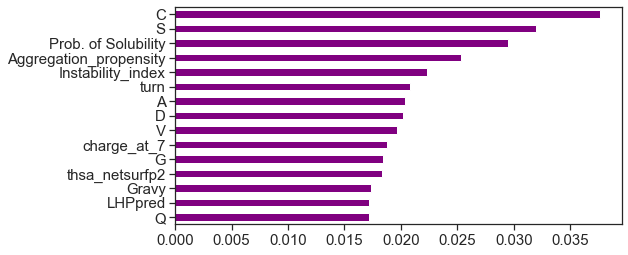

In [44]:
# Extract feature importances
fi = pd.DataFrame({'feature': (Train_feature_list),
                   'importance': rf.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi[:10]
feature_importance = pd.Series(index = df_train.drop('Binary_exp', axis = 1).columns.values, data = rf.feature_importances_)
feature_importance.sort_values(ascending = True)[55:].plot(kind='barh', figsize=(8,4), color="purple",fontsize=15)

fig = plt.gcf()
plt.savefig('Figures/featureImportance.png', dpi=400, bbox_inches='tight')



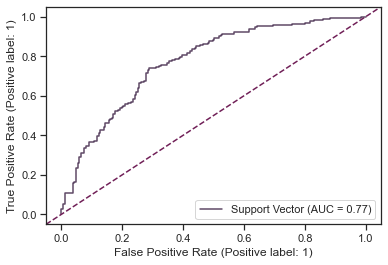

In [45]:
sns.set_palette("rocket")
ax = plt.gca()
svc_disp2 = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

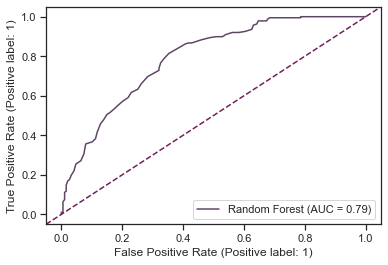

In [46]:
ax = plt.gca()
rf_disp2 = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

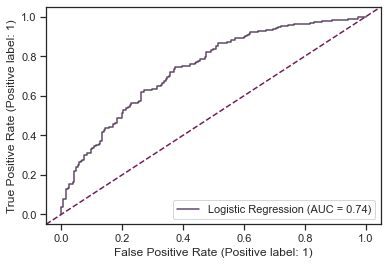

In [47]:
ax = plt.gca()
svc_disp2 = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
plt.show()

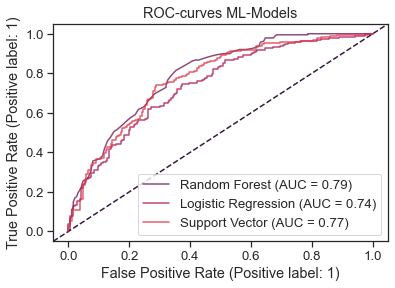

In [48]:
sns.set(style=("ticks"), font_scale=1.2)
sns.set_palette("rocket")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_roc_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_roc_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('ROC-curves ML-Models')
plt.savefig('Figures/ROC.png', dpi=300, bbox_inches='tight')
plt.show()


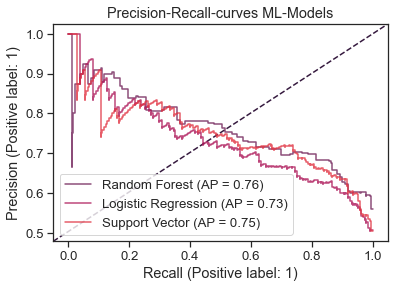

In [49]:
sns.set_palette("rocket")
ax = plt.gca()
ax.plot([0, 1], [0, 1],linestyle='--', transform=ax.transAxes)
rf_disp = plot_precision_recall_curve(rf, Test_features2, Test_labels2,name='Random Forest', ax=ax, alpha=0.8)
lr_disp = plot_precision_recall_curve(lr, Test_features2, Test_labels2,name='Logistic Regression', ax=ax, alpha=0.8)
svc_disp = plot_precision_recall_curve(svc, Test_features2, Test_labels2,name='Support Vector', ax=ax, alpha=0.8)
plt.title('Precision-Recall-curves ML-Models')
plt.savefig('Figures/PRC.png', dpi=300, bbox_inches='tight')
plt.show()

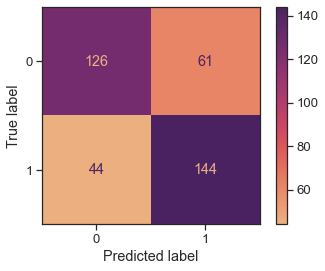

In [50]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(Test_labels2,rf_predictions2)
cm_display = ConfusionMatrixDisplay(cm).plot(cmap="flare")
plt.savefig('Figures/ConfusionMatrix.png', dpi=300, bbox_inches='tight')

In [52]:
from sklearn.metrics import f1_score, matthews_corrcoef, fowlkes_mallows_score
print(f1_score(Test_labels2,rf_predictions2))
print(matthews_corrcoef(Test_labels2,rf_predictions2))
print(fowlkes_mallows_score(Test_labels2,rf_predictions2))

0.732824427480916
0.4416806471549384
0.5964124695913153


## Stratified 10- fold cross validation: AUC

In [53]:
from sklearn.model_selection import train_test_split
SOLtarget = np.array(df_train['Binary_exp'])
SOLdata = np.array(Train_features)

In [54]:
def get_score(model, x_train, x_test, y_train, y_test):
    model.fit(x_train, y_train)
    return model.score(x_test, y_test)

In [55]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits = 10)

In [56]:
AUC_rf = []
for train_index,test_index in kf.split(SOLdata, SOLtarget):
    x_train, x_test, y_train, y_test = SOLdata[train_index], SOLdata[test_index], \
                                        SOLtarget[train_index], SOLtarget[test_index]
    model = RandomForestClassifier(n_estimators = 100)
    AUC_rf.append(get_AUC(model, x_train, x_test, y_train, y_test))
print("Mean AUC score:")
print(np.mean(AUC_rf))

Mean AUC score:
0.8278443248341902


In [57]:
print(np.mean(cross_val_score(LogisticRegression(max_iter = 1000),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(SVC(),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))
print(np.mean(cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)))

0.7775113341333689
0.7989136546315639
0.8267049344415307


In [58]:
roc_rf = cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'roc_auc',cv=10)
f1_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'f1',cv=10)
acc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'accuracy',cv=10)
bacc_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'balanced_accuracy',cv=10)
precision_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'precision',cv=10)
recall_rf =cross_val_score(RandomForestClassifier(n_estimators = 100),SOLdata,SOLtarget,scoring= 'recall',cv=10)





In [59]:
df_roc_rf = pd.DataFrame(roc_rf, columns=["score"])
df_f1_rf =pd.DataFrame(f1_rf, columns=["score"])
df_acc_rf =pd.DataFrame(acc_rf, columns=["score"])
df_bacc_rf =pd.DataFrame(bacc_rf, columns=["score"])
df_precision_rf =pd.DataFrame(precision_rf, columns=["score"])
df_recall_rf = pd.DataFrame(recall_rf, columns=["score"])

df_roc_rf['metric'] = 'AUC'
df_f1_rf['metric'] = 'F1'
df_acc_rf['metric'] = 'ACC'
df_bacc_rf['metric'] = 'BACC'
df_precision_rf['metric'] = 'Precision'
df_recall_rf['metric'] = 'Recall'

df_roc_rf['model'] = 'Expression'
df_f1_rf['model'] = 'Expression'
df_acc_rf['model'] = 'Expression'
df_bacc_rf['model'] = 'Expression'
df_precision_rf['model'] = 'Expression'
df_recall_rf['model'] = 'Expression'

df_scores = pd.concat([df_roc_rf, df_f1_rf, df_acc_rf,df_bacc_rf, df_precision_rf, df_recall_rf])
df_scores
df_scores.to_csv('ExpressionScores.csv')


In [60]:
cols = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light")
#cols = sns.color_palette("Set2")


# Order of categorical variables
cat_order = ['AUC','F1', 'ACC', 'BACC', 'Precision', 'Recall']

# Order of models/test sets
hue_order = ["Expression"]


# Width of error bars
cap_size = 0

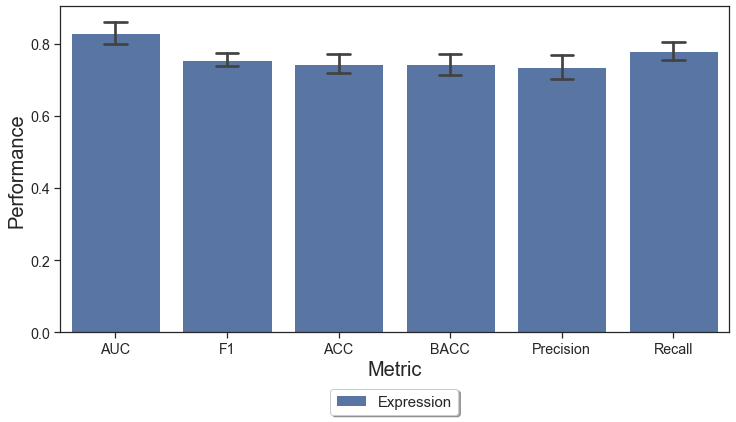

In [61]:
sns.set(style='ticks', font_scale=1.3)
title_size = 14
sat=1

plt.subplots(1, 1, figsize=(12,6), sharey=True)


# bar_colors = {'AUC':df_scores['AUC'], 'F1':df_scores['F1'], 'Acc':df_scores['Acc'],'BAcc':df_scores['BAcc'],
#               'Precision':df_scores['Precision'],'Recall':df_scores['Recall']}

sns.set_style(style = 'white')
sns.barplot(x = "metric", y = "score", data = df_scores,  ci = "sd", capsize=.2, hue="model", order=cat_order, hue_order=hue_order,)

plt.legend(title='Models')
plt.xlabel("Metric", size=20)
plt.ylabel("Performance", size=20)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=True, shadow=True, ncol=5,prop={'size': 15})

# plt.savefig(Figure_path + '/metrics.png', dpi=300, bbox_inches='tight')

In [62]:
d = {'Model': ['Logistic Regression', 
                   'Support Vector', 'Random Forest'],
        'AUC':[0.7506027733903494, 0.7848174926916928, 0.8104367628794037]}
df_test = pd.DataFrame(data=d)

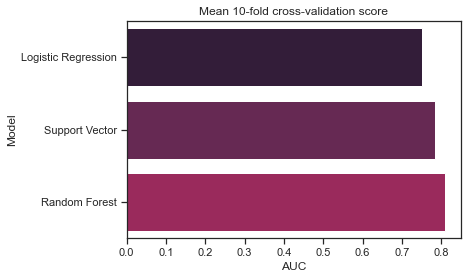

In [63]:
sns.set(style=("ticks"))
sns.set_palette("rocket")
# fig = plt.figure(figsize=(10, 5))

ax = sns.barplot(x="AUC", y="Model", data=df_test, ).set_title('Mean 10-fold cross-validation score')
plt.savefig('Figures/10Fold.png', dpi=300, bbox_inches='tight')

In [64]:
features_continuous = ['length', 'hydr_count', 'polar_count', 'molecular_weight',
       'helix', 'turn', 'sheet', 'A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K',
       'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y', 'thsa_netsurfp2',
       'tasa_netsurfp2', 'rhsa_netsurfp2', 'disorder', 'A_exposed',
       'C_exposed', 'D_exposed', 'E_exposed', 'F_exposed', 'G_exposed',
       'H_exposed', 'I_exposed', 'K_exposed', 'L_exposed', 'M_exposed',
       'N_exposed', 'P_exposed', 'Q_exposed', 'R_exposed', 'S_exposed',
       'T_exposed', 'V_exposed', 'W_exposed', 'Y_exposed',
       'Prob. of Solubility', 'Aggregation_propensity', 'Aromaticity',
       'Instability_index', 'Gravy', 'isoelectric_point', 'charge_at_7',
       'charge_at_5', 'Polar_exposed', 'Hydrophobic_exposed','LHPpred']

features_categorical = ['PTM_MSD', 'Phosphorylation_MSD',
       'Glycosylation_MSD', 'Ubiquitination_MSD', 'SUMOylation_MSD',
       'Acetylation_MSD', 'Palmitoylation_MSD', 'Methylation_MSD']

high_exp = df_train[df_train["Binary_exp"] == 1]
low_exp = df_train[df_train["Binary_exp"] == 0]

In [65]:
high_exp = new_df[new_df["Binary_exp"] == 1]
low_exp = new_df[new_df["Binary_exp"] == 0]

# Violin Plots

## Mann-Whitney U test 

In [66]:
# create Series to save p-values
p_vals = pd.Series(index=features_continuous, dtype="float64", name='p_value')

# calculate p-values using Mann-Whitney U Test
for i, feature in enumerate(features_continuous):
    stat, p = mannwhitneyu(high_exp[feature], low_exp[feature]) # function returns statistic and p-value
    p_vals[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj = fdrcorrection(p_vals)
# create Series to save adjusted p-values
p_vals_adj = pd.Series(data=p_vals_adj, index=features_continuous, name='p_value_adjusted')

In [67]:
# save both p-values in dataframe
p_vals_comb = pd.concat([p_vals, p_vals_adj], axis=1)
# sort by adjusted p-value
p_vals_comb = p_vals_comb.sort_values(by='p_value_adjusted')

In [68]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb)):
    print(p_vals_comb.index[i], 'p=%.5f' % (p_vals_comb.p_value_adjusted[i]))

C p=0.00000
Prob. of Solubility p=0.00000
D p=0.00000
D_exposed p=0.00000
S p=0.00000
K p=0.00000
LHPpred p=0.00000
polar_count p=0.00000
E p=0.00000
rhsa_netsurfp2 p=0.00000
E_exposed p=0.00000
Polar_exposed p=0.00000
charge_at_7 p=0.00000
G p=0.00000
L p=0.00000
A p=0.00000
S_exposed p=0.00000
Aggregation_propensity p=0.00000
K_exposed p=0.00000
thsa_netsurfp2 p=0.00000
C_exposed p=0.00000
Gravy p=0.00000
L_exposed p=0.00000
G_exposed p=0.00000
F_exposed p=0.00000
Hydrophobic_exposed p=0.00000
sheet p=0.00000
charge_at_5 p=0.00000
A_exposed p=0.00000
H_exposed p=0.00000
isoelectric_point p=0.00000
H p=0.00000
hydr_count p=0.00000
W_exposed p=0.00000
Instability_index p=0.00000
I_exposed p=0.00000
F p=0.00000
V_exposed p=0.00000
Aromaticity p=0.00000
T_exposed p=0.00000
helix p=0.00001
N_exposed p=0.00003
V p=0.00008
R p=0.00015
T p=0.00047
N p=0.00089
tasa_netsurfp2 p=0.00127
molecular_weight p=0.00156
length p=0.00204
M p=0.00926
W p=0.01279
Y_exposed p=0.01557
I p=0.01662
M_exposed

## Fishers Exact test

In [69]:
# create Series to save p-values
p_vals_cat = pd.Series(index=features_categorical, dtype="float64", name='p_value')

# calculate p-values using Fisher's exact test
for i, feature in enumerate(features_categorical):
    
    # get counts for each category
    A = sum(high_exp[feature]) # EV & positive
    B = len(high_exp[feature]) - sum(high_exp[feature]) # EV & negative
    C = sum(low_exp[feature]) # no EV & positive
    D = len(low_exp[feature]) - sum(low_exp[feature]) # no EV & negative
    
    # create 2x2 contingency table of counts
    table = np.array([[A, B],
                      [C, D]])
    
    odds, p = fisher_exact(table, alternative='two-sided') # function returns odds ratio and p-value
    p_vals_cat[i] = p 

# calculate adjusted p-value (FDR correction)
rejected, p_vals_adj_cat = fdrcorrection(p_vals_cat)
# create Series to save adjusted p-values
p_vals_adj_cat = pd.Series(data=p_vals_adj_cat, index=features_categorical, name='p_value_adjusted')


In [70]:
# save both p-values in dataframe
p_vals_comb_cat = pd.concat([p_vals_cat, p_vals_adj_cat], axis=1)
# sort by adjusted p-value
p_vals_comb_cat = p_vals_comb_cat.sort_values(by='p_value_adjusted')

In [71]:
# print adjusted p-values (readable)
for i in range(len(p_vals_comb_cat)):
    print(p_vals_comb_cat.index[i], 'p=%.5f' % (p_vals_comb_cat.p_value_adjusted[i]))


Acetylation_MSD p=0.00000
Phosphorylation_MSD p=0.00000
Ubiquitination_MSD p=0.00000
SUMOylation_MSD p=0.00000
Palmitoylation_MSD p=0.00000
Glycosylation_MSD p=0.00000
Methylation_MSD p=0.00008
PTM_MSD p=0.18503


In [72]:
sns.set(style=("ticks"), font_scale=4)
x1, x2 = 0, 1 
dataset = new_df
labels = ["High expression",'Low expression']

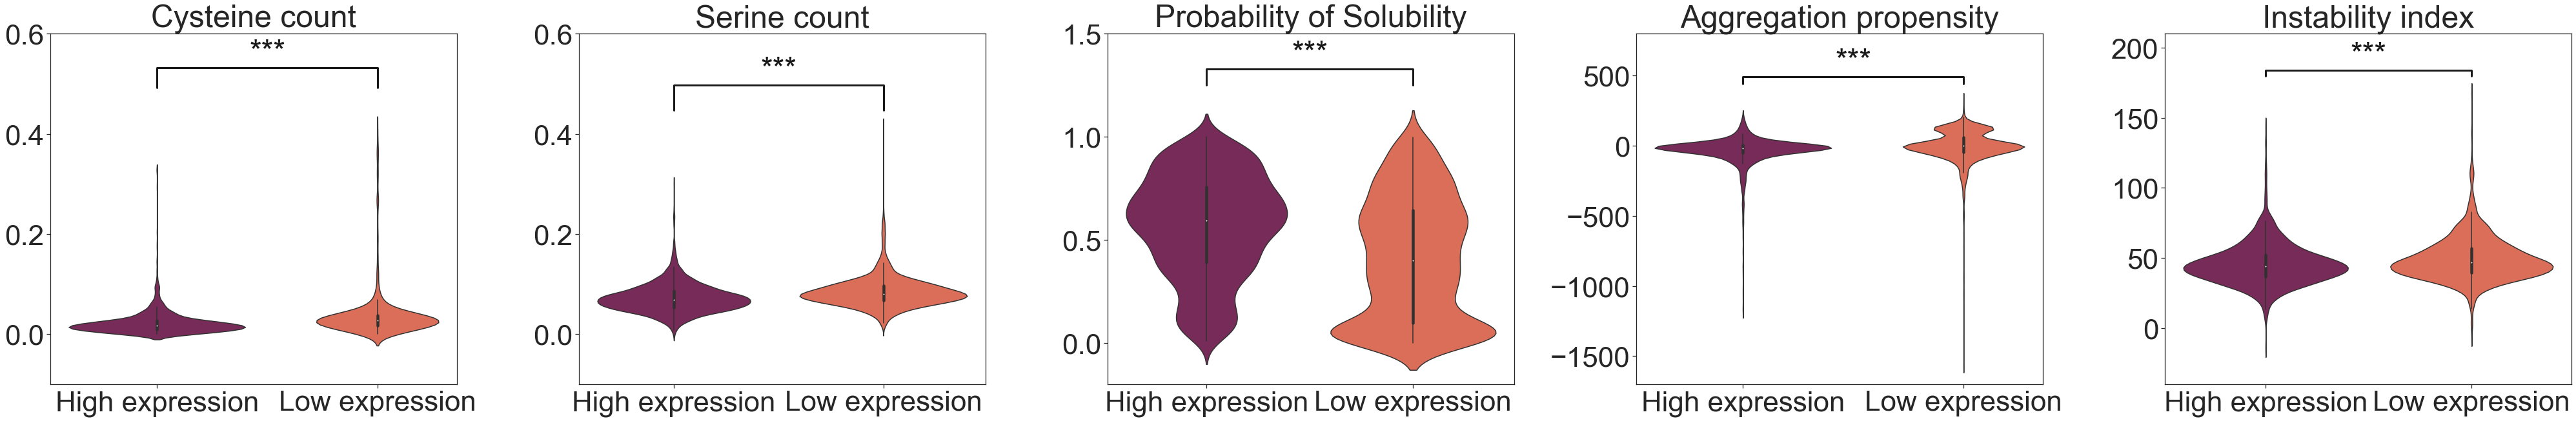

In [89]:
dataset= new_df
fig, (ax1, ax2, ax3, ax4,ax5) = plt.subplots(1, 5, sharey=False, figsize=(70, 10))

sns.violinplot(x="Binary_exp", y='C', data=dataset, ax=ax1, order=[1, 0], palette="rocket")
ax1.set(ylabel=None, xlabel=None, title="Cysteine count", xticklabels=(labels),ylim=(-0.1, 0.6))
y, h, col = dataset['C'].max() + 0.08,0.04 , 'k'
ax1.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax1.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_exp", y='S', data=dataset, ax=ax2, order=[1, 0], palette="rocket")
ax2.set(ylabel=None, xlabel=None, title="Serine count", xticklabels=(labels),ylim=(-0.1, 0.6))
y, h, col = dataset['S'].max() + 0.03, 0.05, 'k'
ax2.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax2.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_exp", y='Prob. of Solubility', data=dataset, ax=ax3, order=[1, 0], palette="rocket")
ax3.set(ylabel=None, xlabel=None, title="Probability of Solubility", xticklabels=(labels),ylim=(-0.2, 1.5))
y, h, col = dataset['Prob. of Solubility'].max() + 0.25, 0.08, 'k'
ax3.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax3.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


sns.violinplot(x="Binary_exp", y='Aggregation_propensity', data=dataset, ax=ax4, order=[1, 0], palette="rocket")
ax4.set(ylabel=None, xlabel=None, title="Aggregation propensity", xticklabels=(labels),ylim=(-1700, 800))
y, h, col = dataset['Aggregation_propensity'].max() + 120, 50, 'k'
ax4.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax4.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)

sns.violinplot(x="Binary_exp", y='Instability_index', data=dataset, ax=ax5, order=[1, 0], palette="rocket")
ax5.set(ylabel=None, xlabel=None, title="Instability index", xticklabels=(labels), ylim=(-40, 210))
y, h, col = dataset['Instability_index'].max() + 12, 4, 'k'
ax5.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=3, c=col)
ax5.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col)


plt.savefig('Figures/ViolinPlots.png', dpi=300, bbox_inches='tight')
plt.subplots_adjust(wspace = 0.3)
plt.show()

## Feature correlation

In [44]:
# calculate pairwise correlation
corr_all = new_df.corr()

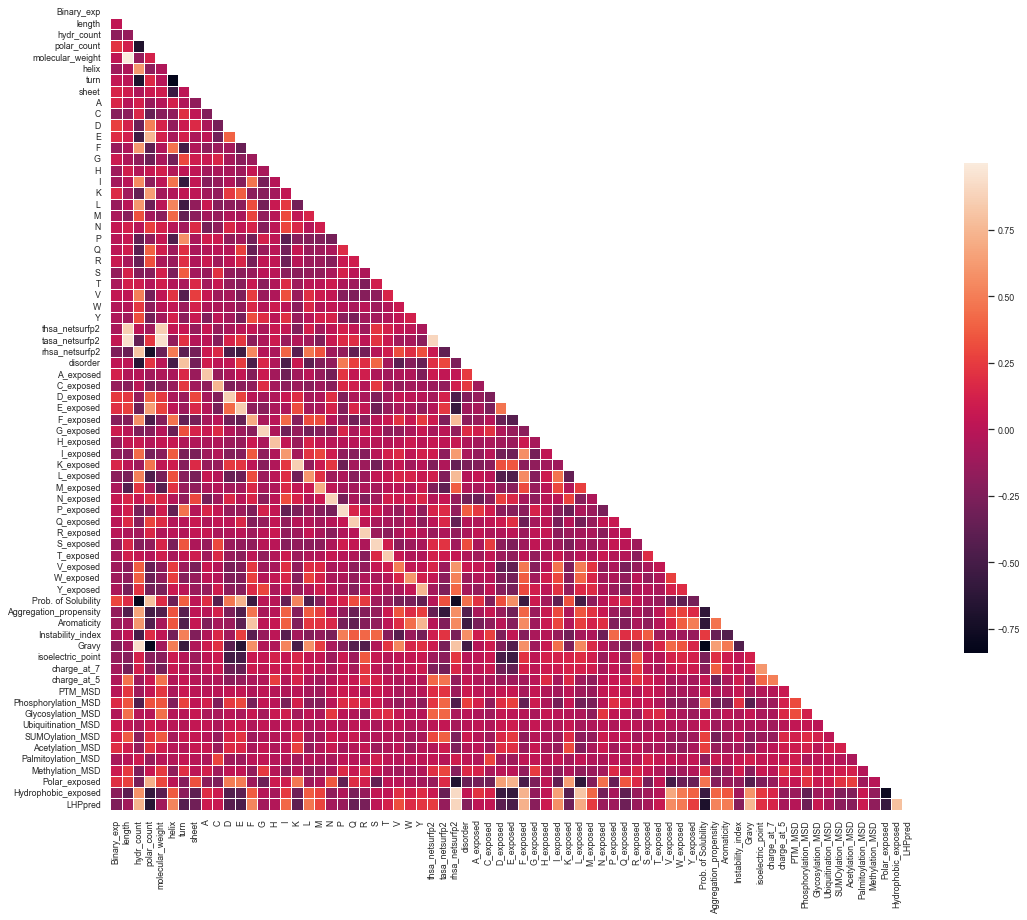

In [45]:
sns.set(font_scale=0.8)

mask = np.triu(np.ones_like(corr_all, dtype=bool))
sns.set_style(style = 'white')
fig, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(10, 250, as_cmap=True)
sns.heatmap(corr_all, mask=mask, cmap="rocket", square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax,
            xticklabels=True, yticklabels=True);
plt.savefig('Figures/Correlations.png', dpi=300, bbox_inches='tight')


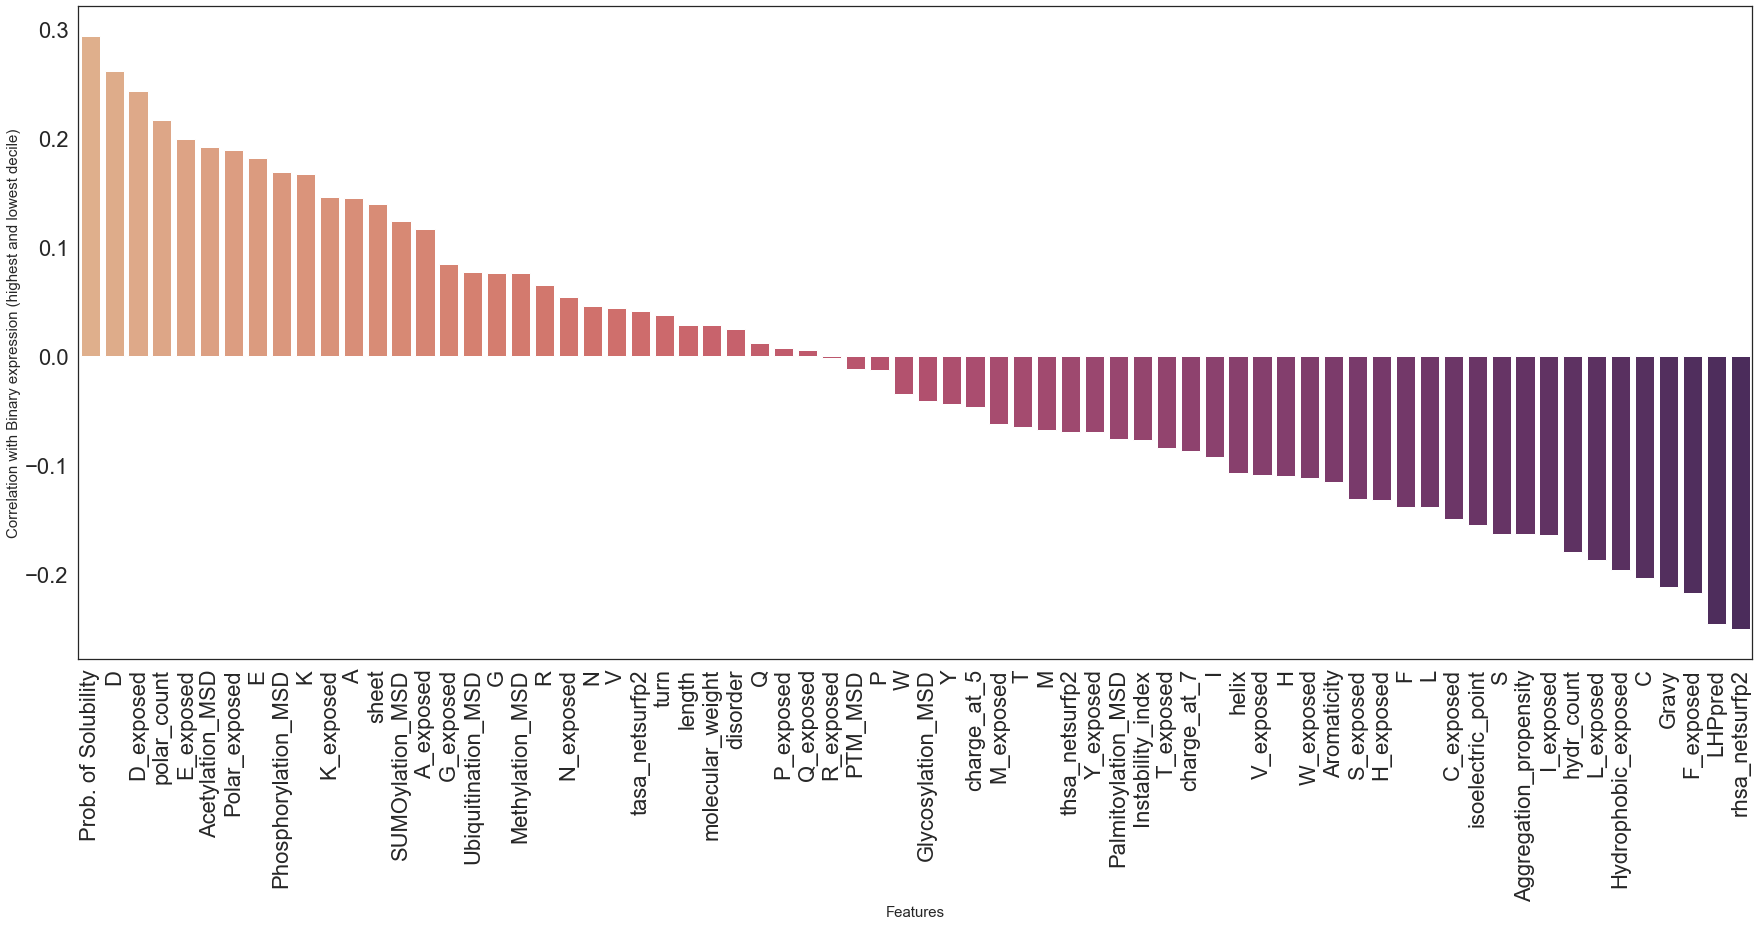

In [98]:
sns.set(style=("white"), font_scale=2)

correlations_all = corr_all[["Binary_exp"]].sort_values(by="Binary_exp", ascending=False)[1:]
correlations_all.reset_index(inplace=True)

colors_all = ["b" if (x > 0) else "r" for x in correlations_all["Binary_exp"]]
fig = plt.figure(figsize=(30, 12)) 
sns.barplot(x="index", y="Binary_exp", data=correlations_all, palette="flare")
plt.xlabel("Features", fontsize = 15) 
plt.xticks(rotation=90)
plt.ylabel("Correlation with Binary expression (highest and lowest decile)",fontsize = 15)
# plt.title("Correlation of features with Normalised Expression")
plt.savefig('Figures/featureCorrelation.png', dpi=300, bbox_inches='tight')